# Modèle de Prédiction des Hospitalisations avec PyCaret

In [1]:
import numpy as np
from pycaret.regression import *
from sklearn.model_selection import train_test_split
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from google.cloud import bigquery
import os

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/antob/Documents/Arctusol/projet_wagon/projet_data_JBN/projet-jbn-data-le-wagon-533639ce801d.json"
        # Initialisation du client BigQuery
client = bigquery.Client()

query = """
SELECT * FROM projet-jbn-data-le-wagon.dbt_medical_analysis_join_total_morbidite.class_join_total_morbidite_sexe_population

"""

df_hospi = client.query(query).to_dataframe()


In [22]:
df_hospi_dpt_ens = df_hospi[(df_hospi["niveau"] == "Départements") & (df_hospi["sexe"] == "Ensemble")]
df_hospi_dpt_HF = df_hospi[(df_hospi["niveau"] == "Départements") & (df_hospi["sexe"] != "Ensemble")]
df_hospi_reg_ens = df_hospi[(df_hospi["niveau"] == "Régions") & (df_hospi["sexe"] == "Ensemble")]
df_hospi_reg_HF = df_hospi[(df_hospi["niveau"] == "Régions") & (df_hospi["sexe"] != "Ensemble")]

In [23]:
df_hospi_dpt_ens_yr = df_hospi_dpt_ens[df_hospi_dpt_ens["annee"].isin([2018, 2019, 2022])]
df_hospi_dpt_HF_yr =df_hospi_dpt_HF[df_hospi_dpt_HF["annee"].isin([2018, 2019, 2022])]
df_hospi_reg_ens_yr = df_hospi_reg_ens[df_hospi_reg_ens["annee"].isin([2018, 2019, 2022])]
df_hospi_reg_HF_yr =df_hospi_reg_HF[df_hospi_reg_HF["annee"].isin([2018, 2019, 2022])]

In [ ]:
"""'hospi_prog_24h', 'hospi_autres_24h', 'hospi_total_24h',
    'hospi_1J', 'hospi_2J', 'hospi_3J', 'hospi_4J', 'hospi_5J',
    'hospi_6J', 'hospi_7J', 'hospi_8J', 'hospi_9J',
    'hospi_10J_19J', 'hospi_20J_29J', 'hospi_30J',
        'tranche_age_0_1', 'tranche_age_1_4', 'tranche_age_5_14',
    'tranche_age_15_24', 'tranche_age_25_34', 'tranche_age_35_44',
    'tranche_age_45_54', 'tranche_age_55_64', 'tranche_age_65_74',
    'tranche_age_75_84', 'tranche_age_85_et_plus'"""

In [24]:
# Préparation des données d'entraînement (2018-2019)
train_data_ens = df_hospi_reg_ens_yr[df_hospi_reg_ens_yr['annee'].isin([2018, 2019])]
test_data_ens = df_hospi_reg_ens_yr[df_hospi_reg_ens_yr['annee'] == 2022]

In [25]:
train_data_hf = df_hospi_reg_HF_yr[df_hospi_reg_HF_yr['annee'].isin([2018, 2019])]
test_data_hf = df_hospi_reg_HF_yr[df_hospi_reg_HF_yr['annee'] == 2022]

In [26]:
# Sélection des variables pertinentes
features = [
    'annee','nom_region', 'nom_pathologie', 'tranche_age_0_1', 'tranche_age_1_4', 'tranche_age_5_14',
    'tranche_age_15_24', 'tranche_age_25_34', 'tranche_age_35_44',
    'tranche_age_45_54', 'tranche_age_55_64', 'tranche_age_65_74',
    'tranche_age_75_84', 'tranche_age_85_et_plus'
]

In [27]:
# Préparation des données pour PyCaret
train_data_ens = train_data_ens[features + ['nbr_hospi']]
test_data_ens = test_data_ens[features + ['nbr_hospi']]
train_data_hf = train_data_hf[features + ['nbr_hospi']]
test_data_hf = test_data_hf[features + ['nbr_hospi']]

In [9]:
s = RegressionExperiment()

In [28]:
# Initialisation de l'environnement PyCaret
s.setup(
    data=train_data_hf,
    target='nbr_hospi',
    session_id=123,
    normalize=True,
    transformation=True,
    ignore_features=['annee'],  # On ignore l'année car on a peu de points temporels
    fold=5,  # 5-fold cross validation
)

,Description,Value
0,Session id,123
1,Target,nbr_hospi
2,Target type,Regression
3,Original data shape,"(11376, 16)"
4,Transformed data shape,"(11376, 32)"
5,Transformed train set shape,"(7963, 32)"
6,Transformed test set shape,"(3413, 32)"
7,Ignore features,1
8,Numeric features,12
9,Categorical features,2


In [29]:
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,291.4584,1172585.9311,1048.7450,0.9746,0.6265,0.4714,0.8000
gbr,Gradient Boosting Regressor,862.6220,3352855.5648,1819.2428,0.9216,1.8616,3.7798,0.4060
lightgbm,Light Gradient Boosting Machine,607.9593,4189314.2970,1996.5258,0.9089,1.3420,1.1477,0.1780
rf,Random Forest Regressor,652.3658,4071934.3614,2000.3209,0.9066,0.7985,0.7813,1.3380
knn,K Neighbors Regressor,776.4917,8900825.6293,2909.0943,0.8088,0.7755,0.3509,0.1200
dt,Decision Tree Regressor,819.9876,9197035.2962,2996.5126,0.7871,0.7537,0.7875,0.1000
br,Bayesian Ridge,2746.0737,27502667.1089,5178.7915,0.3888,2.7901,29.9634,0.0900
ridge,Ridge Regression,2759.1426,27496164.1111,5179.0043,0.3886,2.7988,30.3985,0.1120
llar,Lasso Least Angle Regression,2757.8516,27496980.2686,5179.0092,0.3886,2.7981,30.3509,0.0820
lasso,Lasso Regression,2757.8516,27496980.8736,5179.0094,0.3886,2.7981,30.3511,0.5820


In [41]:
# Comparaison des modèles
best_model = compare_models(
    exclude=['ransac', 'huber', 'theilsen'],  # On exclut les modèles moins pertinents pour ce cas
    sort='R2',  # Trier par R2 score
    n_select=1  # Sélectionner le meilleur modèle
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,210.2197,1674098.7103,1127.0726,0.9912,0.1773,0.0527,0.3640
gbr,Gradient Boosting Regressor,427.6667,2396550.7742,1420.5155,0.9862,0.5982,0.5865,0.2560
rf,Random Forest Regressor,349.7305,3296375.6789,1671.1827,0.9817,0.1999,0.0719,0.7120
dt,Decision Tree Regressor,610.6284,5607087.2998,2317.2817,0.9645,0.3366,0.1542,0.0560
lightgbm,Light Gradient Boosting Machine,501.0182,6291665.5423,2360.0732,0.9639,0.3945,0.1959,0.1180
knn,K Neighbors Regressor,800.0081,10478549.6767,3090.5007,0.9385,0.2794,0.1512,0.0600
ada,AdaBoost Regressor,5000.6533,30007587.1691,5451.3783,0.8026,2.5210,36.7323,0.1200
br,Bayesian Ridge,5146.4878,87145760.0359,9205.0350,0.4519,2.2289,40.2128,0.0520
ridge,Ridge Regression,5159.7623,87114678.7928,9204.7875,0.4518,2.2378,41.0608,0.0460
llar,Lasso Least Angle Regression,5159.5210,87113806.6104,9204.7043,0.4518,2.2394,41.0670,0.0560


In [40]:
# Ajout après la comparaison des modèles
from sklearn.model_selection import cross_val_score

# Validation croisée sur le meilleur modèle
cv_scores = cross_val_score(best_model, train_data.drop('nbr_hospi', axis=1), 
                          train_data['nbr_hospi'], 
                          cv=5, 
                          scoring='r2')

print("Scores de validation croisée (R²):")
print(f"Moyenne: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\generic.py", line 6534, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 414, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 354, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\blocks.py", line 616, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 238, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 183, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 134, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Anémies'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\generic.py", line 6534, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 414, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 354, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\blocks.py", line 616, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 238, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 183, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 134, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Maladies intestinales infectieuses'


In [24]:
# Tuning du meilleur modèle
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,731.6418,3547888.6497,1883.5840,0.9689,0.4504,0.4162
1,862.1841,10623691.8239,3259.4005,0.9404,0.5248,0.5540
2,725.7575,3818782.2306,1954.1705,0.9752,0.5283,0.4961
3,1043.8685,22943884.0537,4789.9775,0.8993,0.5648,0.4763
4,649.8662,2279363.4565,1509.7561,0.9791,0.5447,0.5012
Mean,802.6636,8642722.0429,2679.3777,0.9526,0.5226,0.4888
Std,138.5844,7722273.3861,1209.8170,0.0299,0.0388,0.0445


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Statistiques du nombre d'hospitalisations:
count          5688.0
mean      5637.552215
std      12285.074272
min               0.0
25%             336.0
50%            1546.0
75%           5575.25
max          163601.0
Name: nbr_hospi, dtype: Float64

MAE en pourcentage de la moyenne: 3.74%


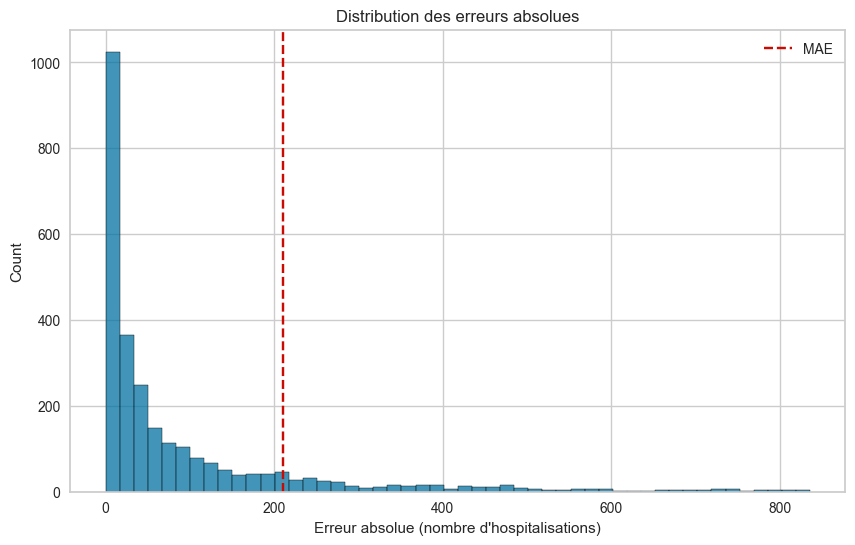

In [16]:
# Analyse du MAE en contexte
print("Statistiques du nombre d'hospitalisations:")
print(train_data['nbr_hospi'].describe())

# Calcul du MAE relatif
mae_relatif = 211 / train_data['nbr_hospi'].mean() * 100
print(f"\nMAE en pourcentage de la moyenne: {mae_relatif:.2f}%")

# Distribution des erreurs
plt.figure(figsize=(10, 6))
erreurs = abs(predictions['nbr_hospi'] - predictions['prediction_label'])
sns.histplot(data=erreurs[erreurs < erreurs.quantile(0.95)], bins=50)
plt.axvline(x=211, color='r', linestyle='--', label='MAE')
plt.title('Distribution des erreurs absolues')
plt.xlabel('Erreur absolue (nombre d\'hospitalisations)')
plt.legend()
plt.show()

In [13]:
# Évaluation sur les données de test (2022)
predictions = predict_model(best_model, data=test_data)
print("Performance sur les données de test (2022):")
print(predictions.head())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,239.1212,1909800.3800,1381.9553,0.9888,0.1573,0.0529


Performance sur les données de test (2022):
        annee code_pathologie  hospi_prog_24h  hospi_autres_24h  \
237376   2022           01001            26.0               4.0   
237378   2022           01002             0.0               0.0   
237383   2022           01003             4.0               3.0   
237386   2022           01004            65.0               0.0   
237388   2022           01005             0.0               0.0   

        hospi_total_24h  hospi_1J  hospi_2J  hospi_3J  hospi_4J  hospi_5J  \
237376             30.0     132.0      80.0      52.0      40.0      15.0   
237378              0.0       0.0       0.0       4.0       0.0       0.0   
237383              7.0      16.0      17.0       8.0       7.0      13.0   
237386             65.0       0.0       0.0       0.0       0.0       0.0   
237388              4.0       3.0       0.0       3.0       3.0       0.0   

        ...  tranche_age_15_24  tranche_age_25_34  tranche_age_35_44  \
237376  ...       

Métriques sur les données de test (2022):
MAE: 239.12
RMSE: 1381.96
R²: 0.9888


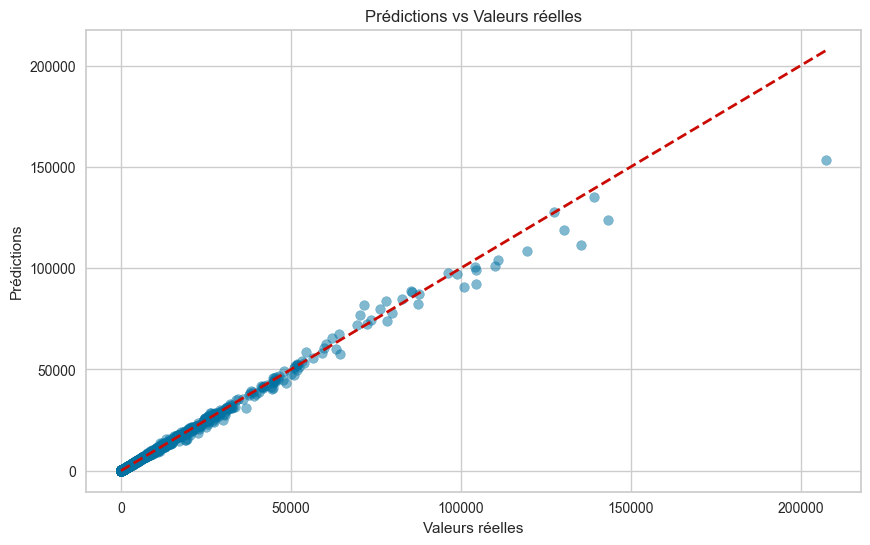


Statistiques des erreurs relatives (%):
count      2862.0
mean          inf
std          <NA>
min           0.0
25%      1.505772
50%      3.386791
75%      6.304061
max           inf
Name: erreur_relative, dtype: Float64


In [14]:
# Calcul des métriques d'erreur pour les prédictions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire les vraies valeurs et les prédictions
y_true = predictions['nbr_hospi']
y_pred = predictions['prediction_label']

# Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Métriques sur les données de test (2022):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.show()

# Calcul et affichage des erreurs relatives
predictions['erreur_relative'] = abs(predictions['nbr_hospi'] - predictions['prediction_label']) / predictions['nbr_hospi'] * 100
print("\nStatistiques des erreurs relatives (%):")
print(predictions['erreur_relative'].describe())